<H1>Conversations with Austin</H1>
<h2>Ad-hoc Template
<p>
<p>

Wait ... who is Austin, you ask? Austin the Apex Duck is my [Rubber Duck Debug buddy](https:en.wikipedia.org/wiki/Rubber_duck_debugging). Usually a pretty quiet type of guy, but I sense hidden depths of knowledge. Our chats usually start with me staring at something for a long time, then asking a question something like: "Hey Austin, what do you know about Kappa?". His usual response is: "Kappa? Tell me more, please". This usually starts a back and forth dialogue where he eggs (no pun intended!) me on to explain more. He's all about putting things in writing, which is why I'm sitting here taking notes which I'm cataloguing in a series called "Chats with Austin".

Salil Athalye
www.oratorvert.com


# Configure Environment and Install Packages


In [1]:
!pip install pmdarima

# Import Libraries


In [2]:
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from google.colab import files



# Set Experiment Parameters


In [3]:
EXPERIMENT_NAME = 'lp_arima_1'
SESSION_ID = 3435
DATA_SOURCE = "https://lp-prod-resources.s3.amazonaws.com/250/43958/2021-02-04-19-15-15/H1.csv"
TARGET_COL = 'IsCanceled'
DOWNLOAD_ZIPFILE = False

In [4]:


dt = datetime.now()
dt.replace(tzinfo=timezone.utc)
utc_timestamp = dt.replace(tzinfo=timezone.utc).isoformat(timespec='seconds')
# Replace ':' and '-' and retain up to seconds
UTC_TIMESTAMP = utc_timestamp.replace(':','').replace('-',"")[:15]


# Load the data


In [5]:

dtype_mapping = {}
data  = pd.read_csv(DATA_SOURCE, dtype=dtype_mapping)


# Save any decisions we took on dtype mapping so we can reuse this in other applications
with open('dtype_mapping.json','w') as f:
  json.dump(dtype_mapping, f)

###Data Description


<p>
Target: IsCanceled, binary




In [6]:
data.shape

(40060, 31)

In [7]:
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   40060 non-null  int64  
 1   LeadTime                     40060 non-null  int64  
 2   ArrivalDateYear              40060 non-null  int64  
 3   ArrivalDateMonth             40060 non-null  object 
 4   ArrivalDateWeekNumber        40060 non-null  int64  
 5   ArrivalDateDayOfMonth        40060 non-null  int64  
 6   StaysInWeekendNights         40060 non-null  int64  
 7   StaysInWeekNights            40060 non-null  int64  
 8   Adults                       40060 non-null  int64  
 9   Children                     40060 non-null  int64  
 10  Babies                       40060 non-null  int64  
 11  Meal                         40060 non-null  object 
 12  Country                      39596 non-null  object 
 13  MarketSegment   

In [9]:
data.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

In [10]:
data.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.000000,40060.00000
mean,0.277634,92.675686,2016.121443,27.140864,15.821243,1.189815,3.128732,1.867149,0.128682,0.013904,0.044383,0.101722,0.146455,0.287968,0.527758,94.952930,0.138068,0.61977
std,0.447837,97.285315,0.722347,14.005441,8.883708,1.147812,2.461329,0.697285,0.445195,0.118998,0.205948,1.335115,1.001955,0.726548,7.428580,61.442418,0.351001,0.81393
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.00000
25%,0.000000,10.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.00000
50%,0.000000,57.000000,2016.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.00000
75%,1.000000,155.000000,2017.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.00000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,30.000000,17.000000,185.000000,508.000000,8.000000,5.00000


In [11]:
data[TARGET_COL].value_counts()

0    28938
1    11122
Name: IsCanceled, dtype: int64

# Perform Basic Exploratory Data Analysis


In [12]:
data['ArrivalDateWW'] = data['ArrivalDateWeekNumber'].map(str)
data['ArrivalDateWW'] = data['ArrivalDateWW'].str.pad(width=2, side='left', fillchar='0')
data['YYYYWW'] = data['ArrivalDateYear'].map(str) + data['ArrivalDateWW']

In [13]:
weekly_cancellations = data[['YYYYWW','IsCanceled']] \
  .groupby(['YYYYWW']) \
  .agg({'IsCanceled':sum})

In [14]:
weekly_cancellations

,IsCanceled
YYYYWW,
201527,41
201528,48
201529,87
201530,74
201531,101
...,...
201731,173
201732,140
201733,182


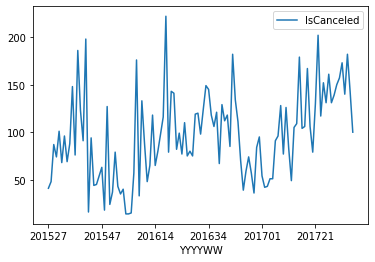

In [15]:
weekly_cancellations.plot()

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf




In [17]:
ts = weekly_cancellations['IsCanceled']

In [18]:
type(ts)

pandas.core.series.Series

In [19]:
ts

YYYYWW
201527     41
201528     48
201529     87
201530     74
201531    101
         ... 
201731    173
201732    140
201733    182
201734    143
201735    100
Name: IsCanceled, Length: 115, dtype: int64

In [20]:
decomposition = seasonal_decompose(ts, freq = 52)
residual = decomposition.resid
trend = decomposition.trend
seasonal = decomposition.seasonal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


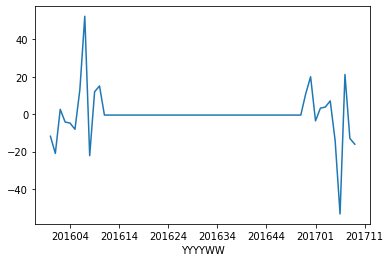

In [21]:
residual.plot()

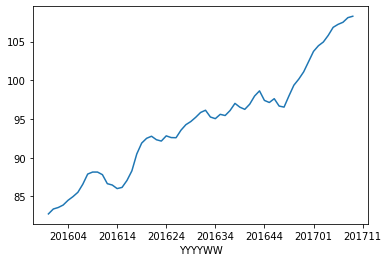

In [22]:
trend.plot()

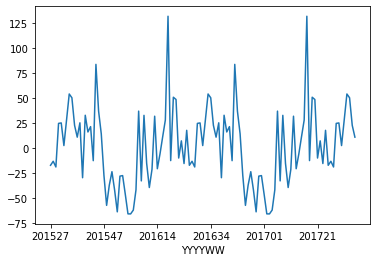

In [23]:
seasonal.plot()

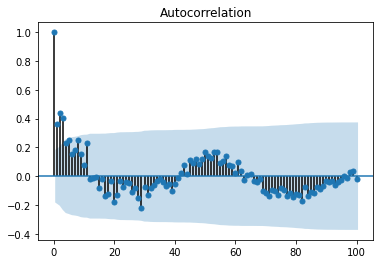

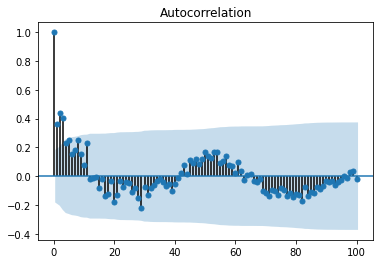

In [24]:
plot_acf(ts, lags=100)

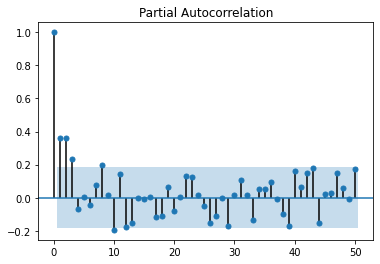

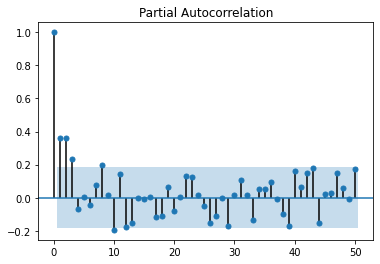

In [25]:
plot_pacf(ts, lags=50)

In [26]:
window = 4
ts_sma4 = ts.rolling(window).mean()

In [27]:
type(ts_sma4)

pandas.core.series.Series

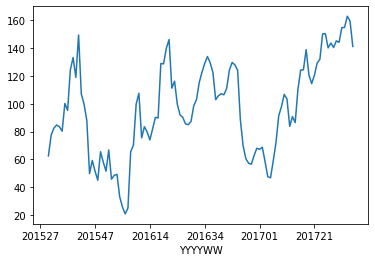

In [28]:
ts_sma4.plot()

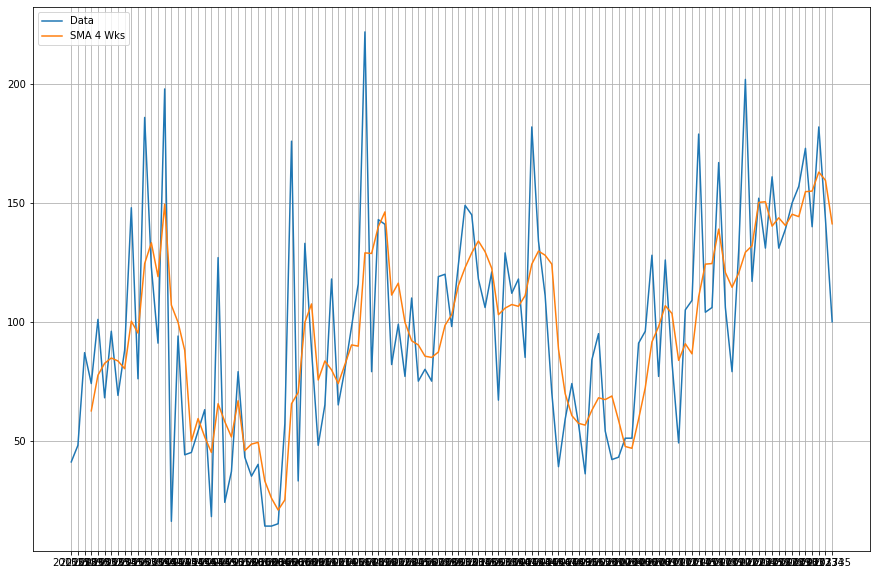

In [29]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(ts, label="Data")
plt.plot(ts_sma4, label='SMA 4 Wks')
plt.legend(loc=2)

In [30]:
ts_len = len(ts)
split_idx = round(ts_len * 0.9)
print(split_idx)
train_ts = ts[0:split_idx]
test_ts = ts[split_idx:]

104


In [31]:
train_ts

YYYYWW
201527     41
201528     48
201529     87
201530     74
201531    101
         ... 
201720     79
201721    130
201722    202
201723    117
201724    152
Name: IsCanceled, Length: 104, dtype: int64

In [32]:
test_ts

YYYYWW
201725    131
201726    161
201727    131
201728    139
201729    150
201730    157
201731    173
201732    140
201733    182
201734    143
201735    100
Name: IsCanceled, dtype: int64

In [45]:
from pmdarima import auto_arima
model=auto_arima(train_ts,
                 start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=51,
                 stepwise=True, 
                 seasonal=True, 
                 information_criterion='bic', 
                 trace=True, 
                 d=1, D=1, 
                 error_action='warn', 
                 suppress_warnings=True, 
                 random_state = 3742828, 
                 n_fits=30)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[51]             : BIC=600.759, Time=0.51 sec
 ARIMA(1,1,0)(1,1,0)[51]             : BIC=inf, Time=5.80 sec
 ARIMA(0,1,1)(0,1,1)[51]             : BIC=inf, Time=6.43 sec
 ARIMA(0,1,0)(1,1,0)[51]             : BIC=inf, Time=4.60 sec
 ARIMA(0,1,0)(0,1,1)[51]             : BIC=inf, Time=7.98 sec
 ARIMA(0,1,0)(1,1,1)[51]             : BIC=606.666, Time=6.60 sec
 ARIMA(1,1,0)(0,1,0)[51]             : BIC=585.398, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[51]             : BIC=inf, Time=6.13 sec
 ARIMA(1,1,0)(1,1,1)[51]             : BIC=591.310, Time=9.60 sec
 ARIMA(2,1,0)(0,1,0)[51]             : BIC=582.690, Time=0.77 sec
 ARIMA(2,1,0)(1,1,0)[51]             : BIC=inf, Time=8.60 sec
 ARIMA(2,1,0)(0,1,1)[51]             : BIC=inf, Time=12.15 sec
 ARIMA(2,1,0)(1,1,1)[51]             : BIC=inf, Time=13.00 sec
 ARIMA(3,1,0)(0,1,0)[51]             : BIC=586.556, Time=1.16 sec
 ARIMA(2,1,1)(0,1,0)[51]             : BIC=inf, Time=1.69 sec
 

In [46]:
model

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 0, 51),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [48]:
forecast=pd.DataFrame(model.predict(n_periods=len(test_ts), index=test_ts.index))




In [49]:
forecast

,0
0,145.855754
1,124.606906
2,184.754942
3,179.322844
4,156.479814
5,185.377701
6,208.493908
7,204.891524
8,178.255282
9,165.841650


In [53]:
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(test_ts,forecast))
print(rmse)

42.08160762158133
